In [1]:
%load_ext autoreload
%autoreload 2

from constructions1D import *
from constructions2D import *
from plt_utils import *
from geometricMultiGrid import *

from functools import partial
from scipy.sparse.linalg import spsolve
from scipy.linalg import norm

# 1.2 1D model problem

## (b)

In [2]:
def helmholtz1D_model(sigma=-600, omega = 2/3,n=64,recursion_depth=5,iterations =50):
    f = pointsource_half(n)
    u_approx = guessv0(n)
    u_exact = spsolve(helmholtz1D(n,sigma),f)
    errors = [u_exact-u_approx] 
    for _ in range(iterations):
        u_approx = geoVcycle(
            mat = partial(helmholtz1D,sigma=sigma), 
            f= f, 
            u = u_approx, 
            nu1=1,
            nu2=1,
            relax=partial(wjacobi,omega= omega), 
            restrict=simple_restrict, 
            interpolate=simple_interpolate, 
            recursion_depth=recursion_depth)
        errors.append(u_exact-u_approx)
    return errors

@interact(
    n=widgets.IntSlider(min=1, max=100, value=64),
    sigma_real=widgets.FloatSlider(min=-10**3, max=10**3, step=1, value=-600,description=r"$R(\sigma)$"),
    sigma_complex=widgets.FloatSlider(min=-10**3, max=10**3, step=1, value=-300,description=r"$im(\sigma)$"),
    omega_real=widgets.FloatSlider(min=-1, max=1, step=0.1, value=2/3,description=r"$R(\omega)$"),
    omega_complex=widgets.FloatSlider(min=-1, max=1, step=0.01, value=-0.1,description=r"$im(\omega)$")
)
def tmp(n,sigma_real,sigma_complex,omega_real,omega_complex):
    sigma = complex(sigma_real,sigma_complex)
    omega = complex(omega_real,omega_complex)
    errors = helmholtz1D_model(sigma=sigma,omega=omega,n=n,recursion_depth=5,iterations =50)
    norms = np.array([norm(e) for e in errors])
    plt.plot(range(len(norms)),np.log10(norms))
    plt.xlabel("Iteration")
    plt.ylabel("log10(norm(error))")
    plt.grid(True)
    plt.title("Convergence of V-cycles")
    plt.show()
    # plt_vecs(errors,[f"errors after {j} vcycles" for j in range(len(errors))]) 

interactive(children=(IntSlider(value=64, description='n', min=1), FloatSlider(value=-600.0, description='$R(\…

## (D)

In [21]:
from ipywidgets import interact,widgets 

@interact(
    n=widgets.IntSlider(min=1, max=200, value=32),
    sigma_real=widgets.FloatSlider(min=-10**3, max=10**3, step=1, value=0),
    sigma_complex=widgets.FloatSlider(min=-10**3, max=10**3, step=1, value=0)
)
def plt_eigen_H(sigma_real,sigma_complex, n):
    sigma = complex(sigma_real,sigma_complex)
    title = rf'eigenvalues of $H$ with $n={n},\sigma = {sigma}$'
    Hs = [helmholtz1D(n*j, sigma) for j in [1,2]]
    labels = [f'$H{j}$' for j in [n,2*n]]
    ys = np.array([eigen_helmhotz1D(n,k,sigma) for k in range(1,n)])
    xs = np.linspace(0,1,len(ys))
    plt.plot(xs,ys.real,label="formula.real",linestyle="--",linewidth=3)
    plt.plot(xs,ys.imag,label="formula.imag",linestyle="--",linewidth=3)
    plt_eigen(Hs,labels,title)


interactive(children=(FloatSlider(value=0.0, description='sigma_real', max=1000.0, min=-1000.0, step=1.0), Flo…

# 1.3
## (b)

In [22]:
from ipywidgets import interact,widgets 

def G(theta,sigma,omega,n):
    return  1-omega+ 2*(omega * n**2)*np.cos(theta)/(2*n**2+sigma)

@interact(
    n=widgets.IntSlider(min=1, max=100, value=64),
    sigma_real=widgets.FloatSlider(min=-10**3, max=10**3, step=1, value=-600),
    sigma_complex=widgets.FloatSlider(min=-10**4, max=10**4, step=1, value=0),
    omega_real=widgets.FloatSlider(min=-1, max=1, step=0.1, value=2/3),
    omega_complex=widgets.FloatSlider(min=-1, max=1, step=0.1, value=0)
)
def plt_eigen_Rw_Gtheta(sigma_real,sigma_complex, omega_real,omega_complex, n):
    sigma = complex(sigma_real,sigma_complex)
    omega = complex(omega_real,omega_complex)
    theta = np.linspace(-np.pi, np.pi, n)
    Gs = G(theta, sigma, omega, n)
    Gs_sorted = np.array(sorted(Gs, key=lambda x: np.abs(
        x)*(0 if x.real == 0 else x.real/np.abs(x.real))))
    plt.clf()
    xs = np.linspace(0, 1, len(Gs))
    plt_R_im_abs(xs,Gs,r"$G(\theta)$")
    plt_R_im_abs(xs,Gs_sorted,r"sorted $G(\theta)$","--")
    plt.grid()
    title = rf'$G(\theta)$ and eigenvalues of $R_\omega$ with  $n={n},\sigma = {sigma}, \omega = {omega}$'
    plt_eigen([Romega(n, sigma,omega)],[r"$R_\omega$"],title)



interactive(children=(FloatSlider(value=-600.0, description='sigma_real', max=1000.0, min=-1000.0, step=1.0), …

## (d)

In [44]:
G(0,-600,2/3,64)

1.0526870389884089

# 1.4
## (a)

In [24]:
def s(j,n):return j if j<=n else n-j
def a(n,k):return 1-np.sin(k*np.pi/(4*n))**2  
n = 2**6
ys = [simple_restrict(wave_basis_1D(2*n,j))/(wave_basis_1D(n,s(j,n))*a(n,j)+0.00001) for j in range(2*n)]
plt_vecs(ys,[f"component wise division between wk"]*len(ys))

interactive(children=(IntSlider(value=0, description='i', max=127), Output()), _dom_classes=('widget-interact'…

In [25]:
n = 2**6
reconstruction_errors = [simple_interpolate(simple_restrict(wk))-wk for wk in [wave_basis_1D(n,k) for k in range(1,n)]]

@interact(
    k=widgets.IntSlider(value=0, min=0, max=len(reconstruction_errors) - 1, description="i")
)
def plt_reconstruction_error(k):
    plt.plot(range(n),np.ones(n)*(k+1)**2*np.pi**2/(6*n**2), label="average error bound")
    plt.legend(loc="upper right")
    plt_vec(reconstruction_errors[k], rf"reconstruction_error for $w_{k+1}$")

interactive(children=(IntSlider(value=0, description='i', max=62), Output()), _dom_classes=('widget-interact',…

## (b)

In [26]:
@interact(
    n=widgets.IntSlider(min=1,max=1000,step=1,value=64),
    sigma_real=widgets.FloatSlider(min=-10**3, max=10**3, step=1, value=-600),
    sigma_complex=widgets.FloatSlider(min=-10**3, max=10**3, step=1, value=0)
)
def plt_rho(n,sigma_real,sigma_complex):
    sigma = complex(sigma_real,sigma_complex)
    ks = np.linspace(1,n,n*10)
    eggs = [1-eigen_helmhotz1D(2*n,k,sigma)/eigen_helmhotz1D(n,k,sigma) for k in ks]
    plt.plot(ks,eggs, label= "1k 10 points")
    ks = np.linspace(1,n,n)
    eggs = [1-eigen_helmhotz1D(2*n,k,sigma)/eigen_helmhotz1D(n,k,sigma) for k in ks]
    plt.plot(ks,eggs, label="1k 1 point")
    plt.legend()
    plt.grid()
    max_index = np.argmax(np.abs(eggs[1:20]))
    print("Index of maximum value in eggs: ", max_index)  
    plt.show()


interactive(children=(IntSlider(value=64, description='n', max=1000, min=1), FloatSlider(value=-600.0, descrip…

# 2.1

## (b)

C:\Users\isido\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:168: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


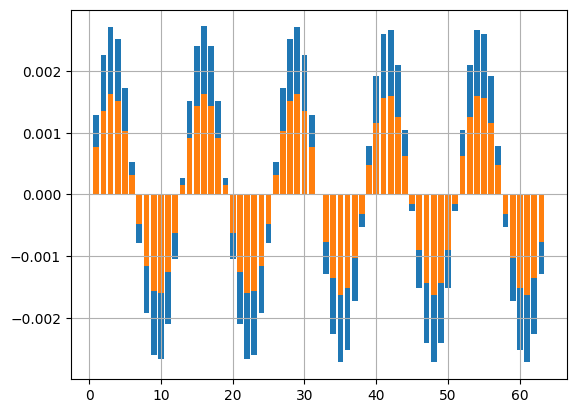

In [27]:
n =64
sigma1 = complex(-600,0)
sigma2 = complex(-600,-300)
# f = pointsource_half(n)
f = wave_basis_1D(n,10)
u_exact1 = spsolve(helmholtz1D(n,sigma1),f)
u_exact2 = spsolve(helmholtz1D(n,sigma2),f)
plt_vec(u_exact1.real)
plt_vec(u_exact2.real)

## (d)


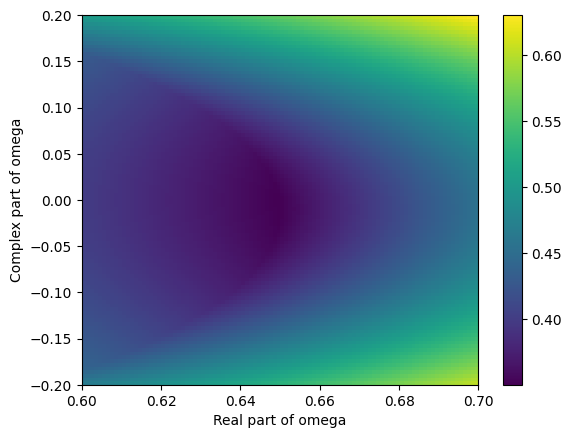

The omega that reaches the minimum is: 0.6494949494949495 + -0.002020202020202033j


In [162]:
import numpy as np
import matplotlib.pyplot as plt

def G(theta, sigma, omega, n):
    return 1 - omega + 2 * (omega * n**2) * np.cos(theta) / (2 * n**2 + sigma)

def max_G(sigma, n, resolution=100):
    omega_real = np.linspace(0.6, 0.7, resolution)
    omega_complex = np.linspace(-0.2, 0.2, resolution)
    max_values = np.zeros((resolution, resolution), dtype=np.float64)

    for i, real_part in enumerate(omega_real):
        for j, complex_part in enumerate(omega_complex):
            omega = complex(real_part, complex_part)
            thetas = np.linspace(np.pi/2, np.pi, 40)
            values = [np.abs(G(theta, sigma, omega, n)) for theta in thetas]
            max_values[j, i] = np.max(values)

    return omega_real, omega_complex, max_values

sigma = complex(-600, -300)
n = 64
omega_real, omega_complex, max_values = max_G(sigma, n)

plt.imshow(max_values, extent=[0.6, 0.7, -0.2, 0.2], origin='lower', cmap='viridis', aspect='auto')
plt.colorbar()
plt.xlabel('Real part of omega')
plt.ylabel('Complex part of omega')
plt.show()

min_value = np.min(max_values)
min_indices = np.where(max_values == min_value)
min_omega_real = omega_real[min_indices[1][0]]
min_omega_complex = omega_complex[min_indices[0][0]]

print(f"The omega that reaches the minimum is: {min_omega_real} + {min_omega_complex}j")

# 2.4
## (a)

In [3]:
def helmholtz2D_model(sigma=complex(-600,-300), omega = 2/3,n=64,recursion_depth=3,iterations =12):
    f = pointsource_half2D(n)
    u_approx = np.zeros((n-1)**2) 
    u_exact = spsolve(helmholtz2D(n,sigma),f)
    errors = [u_exact-u_approx] 
    for _ in range(iterations):
        u_approx = geoVcycle(
            mat = (partial(helmholtz2D,sigma=sigma)), 
            f= f, 
            u = u_approx, 
            nu1=1,
            nu2=1,
            relax=partial(wjacobi,omega= omega), 
            restrict=simple_restrict2D, 
            interpolate=simple_interpolate2D, 
            recursion_depth=recursion_depth,
            dimensions =2)
        errors.append(u_exact-u_approx)
    return errors

errors = helmholtz2D_model(n=128,iterations = 50)
plt_vecs2D(errors,[f"errors after {i} Vcycles" for i in range(len(errors))])

interactive(children=(IntSlider(value=0, description='i', max=50), Output()), _dom_classes=('widget-interact',…

## (b)

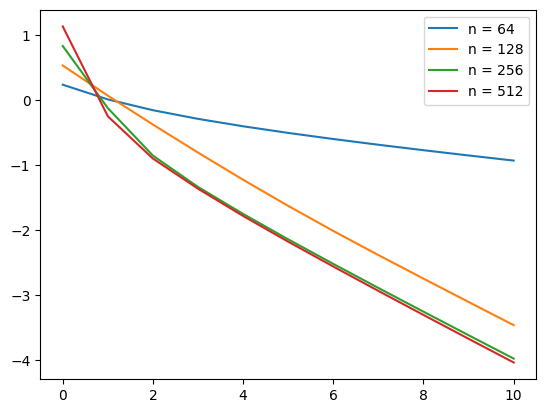

In [8]:
from scipy.linalg import norm

for n in [64,128,256,512]:
    errors = helmholtz2D_model(n=n,iterations = 10) 
    norms =  [norm(e) for e in errors] 
    plt.plot(range(len(errors)), np.log10(norms), label=f"n = {n}")

plt.legend()
plt.show()
